In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
from functools import partial
import joblib

In [2]:
DATADIR = "C:/Users/tmirz/Documents/IJS/"
data = pd.read_csv(os.path.join(DATADIR, "data60.csv"), low_memory=False)
# replace ? for NAN
data = data.replace('?', np.nan)
# Delete rows with missing values
data = data.dropna()
data = data.astype(float)
binary_cols = np.array([col for col in data.columns if "binary" in col])
binary_cols = binary_cols[np.where((data[binary_cols].nunique() <= 2) == True)[0]]
data[binary_cols] = data[binary_cols].astype("O")
data = data.sample(n = 1000, random_state = 42)
target_columns = data.iloc[:,-33:].columns
target = data.loc[:, target_columns].astype(float).sum(axis=1)
data.drop(columns=target_columns, inplace=True)
print(f"Data shape (resolution 60min) : {data.shape}\nNumber of rows {data.shape[0]}\nNumber of columns {data.shape[1]}")

Data shape (resolution 60min) : (1000, 485)
Number of rows 1000
Number of columns 485


In [10]:
df_orange = data
df_orange['target'] = target
df_orange.to_csv('orange_data_2.csv', index=False)

# Evaluacija modelov

## KNN - Regresija
Izbrani parametri modela (grid search):

 * k = 10
 * razdalja : Manhattan
 * utežen vplit najbližnjih sosedov : True

## Neuronske mreže
Parametri:

* hidden layer size : (10, 10)
* learning rate : 0.01
* L2 regularizacija : 0.001

## Odločitvena drvesa
Parametri:

* min_samples_split : 20
* min_samples_leaf : 10
* max_depth : 5

## Metoda podpornih vektorjev
Parametri:

* kernel : rbf
* C : 1
* epsilon : 0.1

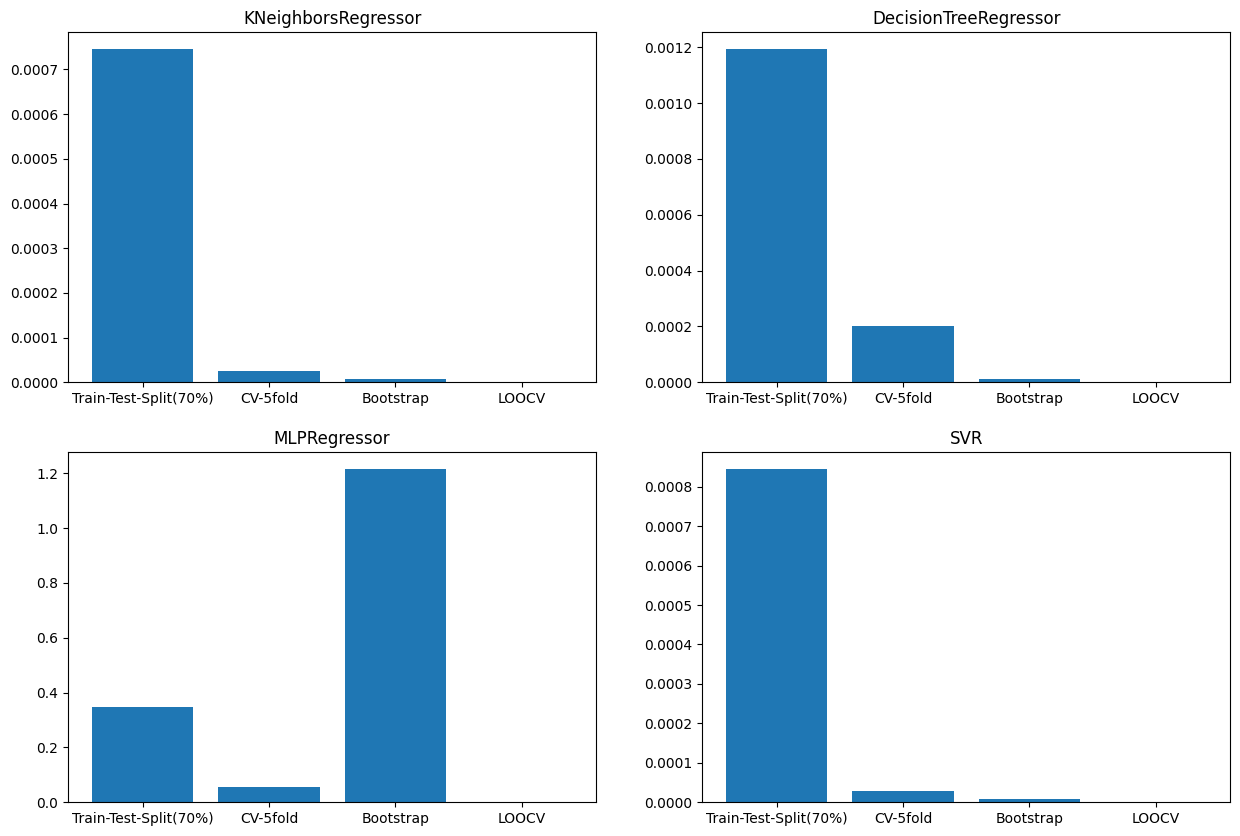

In [64]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

names = ['Train-Test-Split(70%)', 'CV-5fold', 'Bootstrap', 'LOOCV']
row, col = 0, 0
for i, name in enumerate(['KNeighborsRegressor_rmse', 'DecisionTreeRegressor_rmse', 'MLPRegressor_rmse', 'SVR_rmse']):
    
    values = [train_test_results[name]['var'], 
              cv_results[name]['var'],
              bootstrap_results[name]['var'],
              loocv_results[name]['var']]
    
    ax[row, col].bar(names, values)
    ax[row, col].set_title(name[:-5])

    col += 1
    if col == 2:
        row += 1
        col = 0

In [3]:
# Metrics
def rmse(predict, actual):
    predict, actual = np.array(predict), np.array(actual)
    return np.sqrt(np.mean(np.square(actual - predict)))
    # return np.sqrt(np.mean(np.square(actual - predict)) / np.sum(np.square(predict)))

# Model/pipeline definition
numeric_transformer = StandardScaler()

categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, selector(dtype_exclude="category")),
        ("cat", categorical_transformer, selector(dtype_include="category"))
    ]
)

pipe_knn = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('model', KNeighborsRegressor(n_neighbors = 9, p = 1, weights = "distance"))
    ]
)

pipe_nn = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('model', MLPRegressor(hidden_layer_sizes = (10, 10), alpha = 0.001, learning_rate_init = 0.01, max_iter=300))
    ]
)

pipe_tree = Pipeline(
    steps=[
        ('model', DecisionTreeRegressor(max_depth = 5, min_samples_split = 20, min_samples_leaf = 10))
    ]
)

pipe_svr = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('model', SVR(kernel = "rbf", C = 1, epsilon = 0.1))
    ]
)    

# Train test

In [9]:
n_iter = 30
models = [
    pipe_knn, pipe_nn, pipe_tree, pipe_svr
]
train_test_results = {type(model['model']).__name__ + '_rmse': [] for model in models}
np.random.seed(seed=42)
for i in range(n_iter):
    # smaple train test data
    X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.7)
    
    for model in models:    
        # fit models
        model.fit(X_train, y_train)
        
        # calculate predictions
        pred = model.predict(X_test)
    
        # evaluate models
        train_test_results[type(model['model']).__name__ + '_rmse'].append(rmse(pred, y_test))

In [12]:
train_test_results = pd.DataFrame(train_test_results)
train_test_results.to_csv('train_test_results_python.csv', index=False)

In [61]:
train_test_results = pd.read_csv("train_test_results_python.csv")
train_test_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
0,0.642168,1.210056,0.731439,0.573132
1,0.714786,0.816700,0.693217,0.605980
2,0.719588,0.840885,0.735283,0.566931
3,0.672417,2.392765,0.793345,0.603418
4,0.708518,0.755831,0.708333,0.592241
5,0.744396,0.830424,0.717369,0.584740
6,0.668288,0.936842,0.768822,0.591842
7,0.698595,0.854076,0.770534,0.638329
8,0.691477,0.868370,0.727968,0.585928
9,0.678846,0.782551,0.715187,0.565260


In [62]:
train_test_results = pd.DataFrame(train_test_results)[['KNeighborsRegressor_rmse', 
                                                       'MLPRegressor_rmse', 
                                                       'DecisionTreeRegressor_rmse',
                                                       'SVR_rmse']].agg(['mean', 'var']).round(6)
train_test_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
mean,0.687359,1.119996,0.731615,0.599472
var,0.000746,0.345651,0.001194,0.000845


# CV

In [16]:
n_repeats = 30
n_folds = 5
cv_results = {type(model['model']).__name__ + '_rmse': [] for model in models}
cv_results['repeat'] = [j for sub in [[x + 1] * n_folds for x in range(n_repeats)] for j in sub]
cv_results['fold'] = [x + 1 for x in range(n_folds)] * n_repeats

np.random.seed(seed=42)
kf = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)
for i, (train_index, test_index) in enumerate(kf.split(data)):
    # get train test folds
    X_train, y_train = data.iloc[train_index,:], target.iloc[train_index]
    X_test, y_test = data.iloc[test_index,:], target.iloc[test_index]
    
    for model in models:
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        cv_results[type(model['model']).__name__ + '_rmse'].append(rmse(pred, y_test))

In [17]:
cv_results = pd.DataFrame(cv_results)
cv_results.to_csv('cv_results_results_python.csv', index=False)

In [58]:
cv_results = pd.read_csv("cv_results_results_python.csv")
cv_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse,repeat,fold
0,0.586283,0.653836,0.732551,0.554173,1,1
1,0.700167,0.778589,0.715667,0.575779,1,2
2,0.651626,1.352531,0.741083,0.623622,1,3
3,0.706355,0.813727,0.709049,0.574955,1,4
4,0.717620,0.827446,0.777126,0.646431,1,5
...,...,...,...,...,...,...
145,0.723532,1.374752,0.766891,0.596829,30,1
146,0.665839,0.741334,0.667529,0.564776,30,2
147,0.719806,0.824711,0.760178,0.646674,30,3
148,0.643024,0.862039,0.745231,0.590699,30,4


In [59]:
cv_results[['repeat', 
            'KNeighborsRegressor_rmse', 
            'MLPRegressor_rmse', 
            'DecisionTreeRegressor_rmse',
            'SVR_rmse']].groupby('repeat').agg(['mean'])

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
,mean,mean,mean,mean
repeat,,,,
1,0.672410,0.885226,0.735095,0.594992
2,0.681624,0.903704,0.735424,0.592699
3,0.686698,0.990092,0.708226,0.590855
4,0.674208,1.381798,0.731655,0.594201
5,0.682586,1.037322,0.745643,0.591421
6,0.680618,0.891016,0.726601,0.594351
7,0.677207,1.035358,0.716447,0.595061
8,0.684097,1.074036,0.722446,0.599770


In [60]:
cv_results = cv_results[['repeat',
                         'KNeighborsRegressor_rmse', 
                         'MLPRegressor_rmse', 
                         'DecisionTreeRegressor_rmse',
                         'SVR_rmse']].groupby('repeat').agg('mean').agg(['mean', 'var']).round(6)
cv_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
mean,0.683141,1.148709,0.730087,0.596634
var,0.000025,0.056603,0.000202,0.000029


# Boostrap

In [21]:
def parallel_bootstrap(repeat, models, data, target, n_bootstrap_sample, results):
    
    def bootstrap_iteration(i):
        X_train = resample(data, replace=True)
        y_train = target.loc[X_train.index]
        test_idx = [x for x in data.index if x not in X_train.index]
        X_test = data.loc[test_idx, :]
        y_test = target.loc[test_idx]

        for model in models:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            results[type(model['model']).__name__ + '_rmse'].append(rmse(pred, y_test))
    
    for _ in range(n_bootstrap_sample):
        results['repeat'].append(repeat)
        results['bootstrap_sample'].append(_ + 1)
        bootstrap_iteration(_)

    return results

repeats = [x + 1 for x in range(30)]
n_bootstrap_sample = 100
models = [pipe_knn, pipe_nn, pipe_tree, pipe_svr]

results = {type(model['model']).__name__ + '_rmse': [] for model in models}
results['repeat'] = []
results['bootstrap_sample'] = []

partial_parallel_bootstrap = partial(parallel_bootstrap,
                                     models=models,
                                     data=data,
                                     target=target, 
                                     n_bootstrap_sample=n_bootstrap_sample, 
                                     results=results)
np.random.seed(seed=42)
results = joblib.Parallel(n_jobs=-1)(joblib.delayed(partial_parallel_bootstrap)(repeat) for repeat in repeats)

In [22]:
bootstrap_results = results[0].copy()
for i in range(29):
    for key, values in results[i+1].items():
        for val in values:
            bootstrap_results[key].append(val)
bootstrap_results = pd.DataFrame(bootstrap_results)
bootstrap_results.to_csv('bootstrap_results_python.csv', index=False)

In [55]:
bootstrap_results = pd.read_csv("bootstrap_results_python.csv")
bootstrap_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse,repeat,bootstrap_sample
0,0.702319,1.274434,0.716712,0.597389,1,1
1,0.679376,0.844124,0.730002,0.594756,1,2
2,0.733915,1.031409,0.738223,0.622695,1,3
3,0.720180,1.308484,0.758200,0.628957,1,4
4,0.750140,0.859655,0.799873,0.644796,1,5
...,...,...,...,...,...,...
2995,0.671332,1.065737,0.722525,0.610998,30,96
2996,0.718731,0.745712,0.779689,0.599150,30,97
2997,0.760498,1.125730,0.706424,0.637361,30,98
2998,0.759256,0.823168,0.748924,0.620844,30,99


In [56]:
bootstrap_results[['repeat', 
                   'KNeighborsRegressor_rmse', 
                   'MLPRegressor_rmse', 
                   'DecisionTreeRegressor_rmse',
                   'SVR_rmse']].groupby('repeat').agg(['mean'])

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
,mean,mean,mean,mean
repeat,,,,
1,0.714391,1.930366,0.752695,0.611085
2,0.720329,1.319739,0.753006,0.611615
3,0.718473,5.176665,0.758066,0.613588
4,0.711048,1.326060,0.758911,0.603877
5,0.716166,1.170101,0.750423,0.614441
6,0.717790,2.255647,0.758225,0.614749
7,0.715861,1.234488,0.758108,0.613324
8,0.720014,1.327904,0.763744,0.613167


In [57]:
bootstrap_results = bootstrap_results[['repeat',
                                       'KNeighborsRegressor_rmse', 
                                       'MLPRegressor_rmse', 
                                       'DecisionTreeRegressor_rmse',
                                       'SVR_rmse']].groupby('repeat').agg('mean').agg(['mean', 'var']).round(6)
bootstrap_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
mean,0.715956,1.844053,0.756597,0.611743
var,0.000007,1.215649,0.000012,0.000008


# LOOCV

In [27]:
loocv_results = {type(model['model']).__name__ + '_rmse': [] for model in models}
loocv_results['repeat'] = []
loocv_results['iteration'] = []
repeats = [x + 1 for x in range(30)]

def parallel_loocv(repeat, models, data, target, results):
    loo = LeaveOneOut()
    for i, (train_index, test_index) in enumerate(loo.split(data)):
        results['iteration'].append(i+1)
        results['repeat'].append(repeat)
        # get train test folds
        X_train, y_train = data.iloc[train_index,:], target.iloc[train_index]
        X_test, y_test = data.iloc[test_index,:], target.iloc[test_index]
        
        for model in models:
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            results[type(model['model']).__name__ + '_rmse'].append(rmse(pred, y_test))
    return results

partial_parallel_loocv = partial(parallel_loocv,
                                 models=models,
                                 data=data,
                                 target=target, 
                                 results=loocv_results)
np.random.seed(seed=42)
loocv_results = joblib.Parallel(n_jobs=-1)(joblib.delayed(partial_parallel_loocv)(repeat) for repeat in repeats)

In [32]:
loocv_results1 = loocv_results[0].copy()
for i in range(29):
    for key, values in loocv_results[i+1].items():
        for val in values:
            loocv_results1[key].append(val)
loocv_results1 = pd.DataFrame(loocv_results1)
loocv_results1.to_csv('loocv_results_python.csv', index=False)

In [48]:
loocv_results = pd.read_csv("loocv_results_python.csv")
loocv_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse,repeat,iteration
0,0.096898,0.240066,0.484190,0.267091,1,1
1,0.174750,0.885624,0.570629,0.072396,1,2
2,0.536213,0.566918,0.633766,0.181227,1,3
3,0.370570,0.362838,0.064262,0.592106,1,4
4,0.329009,0.019680,1.220286,0.032343,1,5
...,...,...,...,...,...,...
29995,0.075771,0.523664,0.783178,0.303151,30,996
29996,0.259055,0.628366,0.202657,0.443855,30,997
29997,0.146559,0.055876,0.385862,0.151475,30,998
29998,0.309246,0.829926,0.407712,0.064698,30,999


In [50]:
loocv_results[['repeat',
              'KNeighborsRegressor_rmse', 
              'MLPRegressor_rmse', 
              'DecisionTreeRegressor_rmse',
              'SVR_rmse']].groupby('repeat').agg('mean')

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
repeat,,,,
1,0.534355,0.613414,0.514984,0.446493
2,0.534355,0.644144,0.514928,0.446493
3,0.534355,0.659476,0.514928,0.446493
4,0.534355,0.614530,0.514984,0.446493
5,0.534355,0.593972,0.514928,0.446493
6,0.534355,0.651810,0.514984,0.446493
7,0.534355,0.596563,0.514984,0.446493
8,0.534355,0.651205,0.514984,0.446493
9,0.534355,0.595922,0.514928,0.446493


In [63]:
loocv_results = loocv_results[['repeat',
                               'KNeighborsRegressor_rmse', 
                               'MLPRegressor_rmse', 
                               'DecisionTreeRegressor_rmse',
                               'SVR_rmse']].groupby('repeat').agg('mean').agg(['mean', 'var']).round(6)
loocv_results

,KNeighborsRegressor_rmse,MLPRegressor_rmse,DecisionTreeRegressor_rmse,SVR_rmse
mean,0.534355,0.627206,0.514961,0.446493
var,0.000000,0.000802,0.000000,0.000000
